In [1]:
pwd

'/home/dcor/niskhizov/Rar'

In [2]:
cd object-detection-nn

/home/dcor/niskhizov/Rar/object-detection-nn


In [3]:
import sys
import os

from nn.YOLO_VGG16.utils.constants import ANCHORS
from nn.YOLO_VGG16.prepare_data.coco_dataset import CocoDataset
from nn.YOLO_VGG16.prepare_data.transforms import test_transform
from nn.YOLO_VGG16.utils.helpers import convert_cells_to_bboxes, get_coco_index_lable_map, load_checkpoint, nms, plot_image
from nn.YOLO_VGG16.utils.constants import device, s, leanring_rate, checkpoint_file
from nn.YOLO_VGG16.model.YOLO_VGG16 import YOLO_VGG16
import torch
import torch.optim as optim
from nn.YOLO_VGG16.model.loss import YOLOLoss
from pycocotools.coco import COCO

/home/dcor/niskhizov/anaconda3/envs/obj_d/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
model_path = "/home/dcor/niskhizov/Rar/object-detection-nn/nn/YOLO_VGG16/degug_notebooks/vgg_f_model" + f"e8_vgg16_{checkpoint_file}"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"{model_path} not found")

In [5]:
coco_path = '/home/dcor/niskhizov/Rar/object-detection-nn/nn/YOLO_VGG16/degug_notebooks/temp/instances_val2017.json'

coco = COCO(coco_path)
categories = ["dog"]

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!


In [6]:
# Setting the load_model to True 
load_model = True
  
# Defining the model, optimizer, loss function and scaler 
model = YOLO_VGG16(num_classes=len(categories)).to(device) 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 
loss_fn = YOLOLoss() 
scaler = torch.amp.GradScaler(device=device) 

In [7]:
# Loading the checkpoint 
if load_model: 
    load_checkpoint(model_path, model, optimizer, leanring_rate, device) 


==> Loading checkpoint


In [8]:
dataset = CocoDataset( 
	coco_obj=coco, 
	categories=categories,
	grid_sizes=[13, 26, 52], 
	anchors=ANCHORS, 
	transform=test_transform 
) 

# Defining the train data loader 
test_loader = torch.utils.data.DataLoader( 
	dataset=dataset, 
	batch_size=1, 
	shuffle=True, 
) 

# Getting a sample image from the test data loader 
x, y = next(iter(test_loader)) 
x = x.to(device) 
  
model.eval() 


YOLO_VGG16(
  (layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


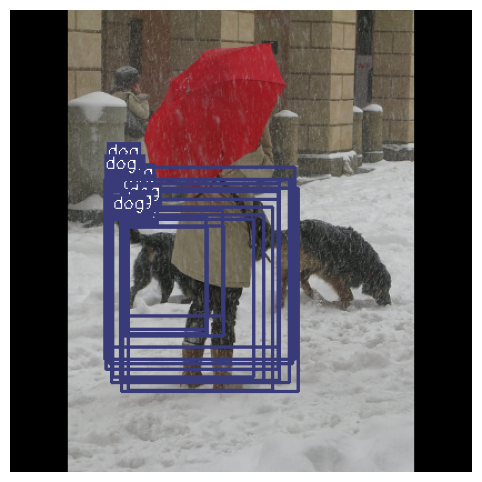

In [14]:
# x, y = next(iter(test_loader)) 
# x = x.to(device) 

with torch.no_grad(): 
    # Getting the model predictions 
    output = model(x) 
    # Getting the bounding boxes from the predictions 
    bboxes = [[] for _ in range(x.shape[0])] 
    anchors = ( 
            torch.tensor(ANCHORS) 
                * torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2) 
            ).to(device) 
  
    # Getting bounding boxes for each scale 
    for i in range(3): 
        batch_size, A, S, _, _ = output[i].shape 
        anchor = anchors[i] 
        boxes_scale_i = convert_cells_to_bboxes( 
                            output[i], anchor, s=S, is_predictions=True
                        ) 
        for idx, (box) in enumerate(boxes_scale_i): 
            bboxes[idx] += box 
model.train() 
  
# Plotting the image with bounding boxes for each image in the batch 
for i in range(batch_size): 
    # Applying non-max suppression to remove overlapping bounding boxes 
    nms_boxes = nms(bboxes[i], iou_threshold=0.4, threshold=0.6) 
    # Plotting the image with bounding boxes 
    plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes, categories)


In [10]:
scaled_anchors = ( 
	torch.tensor(ANCHORS) *
	torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
).to(device) 

In [61]:
loss_fn(output[0], output[0],scaled_anchors[0])

tensor(nan, device='cuda:0')

In [63]:
sigmoid = torch.nn.Sigmoid()

In [64]:
obj = sigmoid(output[0][..., 0]) == 1
no_obj = sigmoid(output[0][..., 0]) == 0

# print numbers of object and no object
print("Number of object predictions: ", obj.sum().item())
print("Number of no object predictions: ", no_obj.sum().item())

Number of object predictions:  0
Number of no object predictions:  0


In [65]:
sigmoid(output[0][..., 0])

tensor([[[[0.0124, 0.0104, 0.0086, 0.0079, 0.0040, 0.0037, 0.0042, 0.0049,
           0.0052, 0.0046, 0.0060, 0.0063, 0.0087],
          [0.0102, 0.0069, 0.0086, 0.0098, 0.0150, 0.0065, 0.0035, 0.0051,
           0.0092, 0.0108, 0.0146, 0.0092, 0.0121],
          [0.0100, 0.0041, 0.0074, 0.0170, 0.0120, 0.0099, 0.0070, 0.0115,
           0.0239, 0.0435, 0.0821, 0.0670, 0.0196],
          [0.0108, 0.0036, 0.0083, 0.0072, 0.0051, 0.0048, 0.0082, 0.0186,
           0.0378, 0.1218, 0.1355, 0.0967, 0.0406],
          [0.0269, 0.0113, 0.0037, 0.0034, 0.0030, 0.0121, 0.0090, 0.0047,
           0.0444, 0.0794, 0.2077, 0.4278, 0.1749],
          [0.1286, 0.0494, 0.0039, 0.0103, 0.0065, 0.0068, 0.0114, 0.0052,
           0.0321, 0.0704, 0.1172, 0.1124, 0.0507],
          [0.2413, 0.2760, 0.0332, 0.0128, 0.0062, 0.0051, 0.0099, 0.0155,
           0.0344, 0.1020, 0.1843, 0.1172, 0.0269],
          [0.1115, 0.2939, 0.2227, 0.2195, 0.0625, 0.0147, 0.0200, 0.0304,
           0.1886, 0.3162, 0.3886, 0